In [10]:
import torch
import torchvision
import torchvision.transforms as transforms

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define data transformations
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert the image to a PyTorch tensor
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize pixel values to range [-1, 1]
])

# Load the training dataset
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, transform=transform, download=True)

# Load the testing dataset
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, transform=transform, download=True)


Files already downloaded and verified
Files already downloaded and verified


In [11]:
from keras . datasets import cifar10
# Load the CIFAR -10 dataset
( train_images , train_labels ) , ( test_images ,test_labels ) = cifar10 . load_data ()

In [12]:
from torch.utils.data import random_split

# Define the ratios for splitting the dataset
total_length = len(train_dataset)
train_ratio = 0.6
val_ratio = 0.2
test_ratio = 0.2

# Calculate the lengths of subsets
train_length = int(train_ratio * total_length)
val_length = int(val_ratio * total_length)
test_length = total_length - train_length - val_length

# Split the dataset into training, validation, and testing subsets
train_dataset, val_dataset, test_dataset = random_split(train_dataset, [train_length, val_length, test_length])


In [13]:
# Hyper-parameters
batch_size = 64

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,shuffle=True)

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,shuffle=False)

val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, num_workers=4)


classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Epoch [1/20] - Training Loss: 2.0971 - Validation Loss: 2.0161
Epoch [2/20] - Training Loss: 2.0212 - Validation Loss: 1.9903
Epoch [3/20] - Training Loss: 1.9629 - Validation Loss: 1.9151
Epoch [4/20] - Training Loss: 1.9248 - Validation Loss: 1.8898
Epoch [5/20] - Training Loss: 1.8962 - Validation Loss: 1.8624
Epoch [6/20] - Training Loss: 1.8805 - Validation Loss: 1.8438
Epoch [7/20] - Training Loss: 1.8670 - Validation Loss: 1.8542
Epoch [8/20] - Training Loss: 1.8551 - Validation Loss: 1.8162
Epoch [9/20] - Training Loss: 1.8419 - Validation Loss: 1.8316
Epoch [10/20] - Training Loss: 1.8337 - Validation Loss: 1.8236
Epoch [11/20] - Training Loss: 1.8238 - Validation Loss: 1.8220
Epoch [12/20] - Training Loss: 1.8169 - Validation Loss: 1.7970
Epoch [13/20] - Training Loss: 1.8111 - Validation Loss: 1.7985
Epoch [14/20] - Training Loss: 1.8012 - Validation Loss: 1.7940
Epoch [15/20] - Training Loss: 1.7961 - Validation Loss: 1.7943
Epoch [16/20] - Training Loss: 1.7877 - Validatio

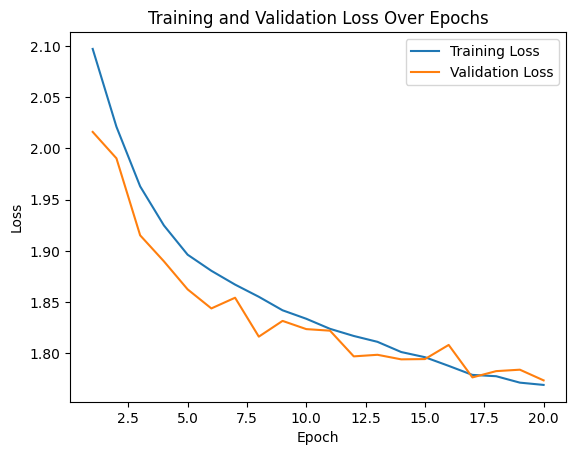

In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.optim.lr_scheduler import ReduceLROnPlateau
import matplotlib.pyplot as plt

# Assuming train_loader, validation_loader, and other necessary variables are defined.

x1 = 32
m1 = 5
x2 = 64
m2 = 5
x3 = 128
d = 0.5

class ConvNet(nn.Module):
    def __init__(self, x1, m1, x2, m2, x3, d):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(3, x1, m1)
        self.bn1 = nn.BatchNorm2d(x1)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(x1, x2, m2)
        self.bn2 = nn.BatchNorm2d(x2)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(x2 * 5 * 5, x3)
        self.dropout = nn.Dropout(d)
        self.fc2 = nn.Linear(x3, 10)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool1(x)
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool2(x)
        x = x.view(-1, x2 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.softmax(self.fc2(x), dim=1)
        return x

# Assuming train_loader, validation_loader, and other necessary variables are defined.
# Initialize the model, criterion, and optimizer
model = ConvNet(x1, m1, x2, m2, x3, d)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

# Learning rate scheduler
scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.1, verbose=True)

# Set the number of training epochs
num_epochs = 20
best_validation_loss = float('inf')

train_loss_history = []
validation_loss_history = []

# Training loop
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    train_loss = train_loss / len(train_loader)
    train_loss_history.append(train_loss)

    # Validation
    model.eval()
    validation_loss = 0.0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            validation_loss += loss.item()

    validation_loss = validation_loss / len(val_loader)
    validation_loss_history.append(validation_loss)

    # Learning rate scheduler step
    scheduler.step(validation_loss)

    

    # Print training and validation loss at each epoch
    print(f'Epoch [{epoch + 1}/{num_epochs}] - Training Loss: {train_loss:.4f} - Validation Loss: {validation_loss:.4f}')

# Plot the training and validation loss
plt.plot(range(1, num_epochs + 1), train_loss_history, label='Training Loss')
plt.plot(range(1, num_epochs + 1), validation_loss_history, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()


In [15]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Evaluation on the testing dataset
model.eval()
test_predictions = []
test_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        test_predictions.extend(predicted.cpu().numpy())
        test_labels.extend(labels.cpu().numpy())


# Calculate accuracy
test_accuracy = accuracy_score(test_labels, test_predictions)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

# Confusion Matrix
conf_matrix = confusion_matrix(test_labels, test_predictions)
print('Confusion Matrix:')
print(conf_matrix)

# Classification Report (Precision, Recall, F1-score, Support)
class_names = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
class_report = classification_report(test_labels, test_predictions, target_names=class_names)
print('Classification Report:')
print(class_report)

# Calculate train accuracy (optional)
train_predictions = []
train_labels = []

model.eval()
with torch.no_grad():
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        train_predictions.extend(predicted.cpu().numpy())
        train_labels.extend(labels.cpu().numpy())
        
train_accuracy = accuracy_score(train_labels, train_predictions)
print(f'Train Accuracy: {train_accuracy * 100:.2f}%')


Test Accuracy: 68.75%
Confusion Matrix:
[[725  28  71  17  26  17   4  17  74  25]
 [ 21 827   7   8   3  13   9  15  12  33]
 [ 84   3 625  64  77  84  43  41  13   7]
 [ 30   5  84 470  37 250  53  23  16   6]
 [ 49   3  73  78 618  65  23  68   7   4]
 [ 12   2  64 143  43 670  18  39   3   3]
 [  9   7  85  65  42  61 658   7   7   2]
 [ 11   2  47  34  52 120   3 712   5   5]
 [ 81  37  16  23   9  14   7   8 851  26]
 [ 46 139  11  25   3  24   8  35  32 719]]
Classification Report:
              precision    recall  f1-score   support

       plane       0.68      0.72      0.70      1004
         car       0.79      0.87      0.83       948
        bird       0.58      0.60      0.59      1041
         cat       0.51      0.48      0.49       974
        deer       0.68      0.63      0.65       988
         dog       0.51      0.67      0.58       997
        frog       0.80      0.70      0.74       943
       horse       0.74      0.72      0.73       991
        ship       

**FineTuning ResNet**

In [1]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.optimizers import Adam

# Load the CIFAR-10 dataset
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()
train_images, test_images = train_images / 255.0, test_images / 255.0

# Load ResNet50 pre-trained on ImageNet without the top (classification) layer
resnet_base = ResNet50(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

# Create a new model using the ResNet50 base
model_resnet = models.Sequential()
model_resnet.add(resnet_base)
model_resnet.add(layers.GlobalAveragePooling2D())
model_resnet.add(layers.Dense(10, activation='softmax'))  # CIFAR-10 has 10 classes

# Compile the model
model_resnet.compile(optimizer=Adam(learning_rate=1e-4),
                     loss='sparse_categorical_crossentropy',
                     metrics=['accuracy'])

# Fine-tune the model on CIFAR-10
model_resnet.fit(train_images, train_labels, epochs=10, validation_data=(test_images, test_labels))


Epoch 1/10
1563/1563 [==============================] - 1737s 1s/step - loss: 1.3220 - accuracy: 0.5697 - val_loss: 0.9716 - val_accuracy: 0.6926
Epoch 2/10
1563/1563 [==============================] - 1709s 1s/step - loss: 0.7429 - accuracy: 0.7477 - val_loss: 0.7951 - val_accuracy: 0.7520
Epoch 3/10
1563/1563 [==============================] - 1709s 1s/step - loss: 0.5537 - accuracy: 0.8123 - val_loss: 0.8453 - val_accuracy: 0.7635
Epoch 4/10
1563/1563 [==============================] - 1718s 1s/step - loss: 0.4377 - accuracy: 0.8503 - val_loss: 0.6501 - val_accuracy: 0.7905
Epoch 5/10
1563/1563 [==============================] - 1698s 1s/step - loss: 0.3363 - accuracy: 0.8834 - val_loss: 0.6727 - val_accuracy: 0.7961
Epoch 6/10
1563/1563 [==============================] - 1693s 1s/step - loss: 0.2619 - accuracy: 0.9115 - val_loss: 0.7138 - val_accuracy: 0.7968
Epoch 7/10
1563/1563 [==============================] - 1700s 1s/step - loss: 0.2184 - accuracy: 0.9261 - val_loss: 0.6498 -

In [8]:
# Evaluate the fine-tuned ResNet model on the testing dataset

313/313 [==============================] - 30s 94ms/step - loss: 0.7260 - accuracy: 0.8177
Test Accuracy of the Fine-tuned ResNet on CIFAR-10: 81.77%
